 # Goal: Build two to three different models and identify the best one.
     - Fit your models with a training dataset
     - Review model outcomes — Iterate over additional models as needed
     - Identify the model that you think is the best model for this project

#### 0 = No Purhcase 
#### 1 = Purchase

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc

In [4]:
df = pd.read_csv('cleaned_cust_data.csv')

In [5]:
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1388 non-null   int64  
 1   Gender              1388 non-null   int64  
 2   AnnualIncome        1388 non-null   float64
 3   NumberOfPurchases   1388 non-null   int64  
 4   ProductCategory     1388 non-null   int64  
 5   TimeSpentOnWebsite  1388 non-null   float64
 6   LoyaltyProgram      1388 non-null   int64  
 7   DiscountsAvailed    1388 non-null   int64  
 8   PurchaseStatus      1388 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 97.7 KB


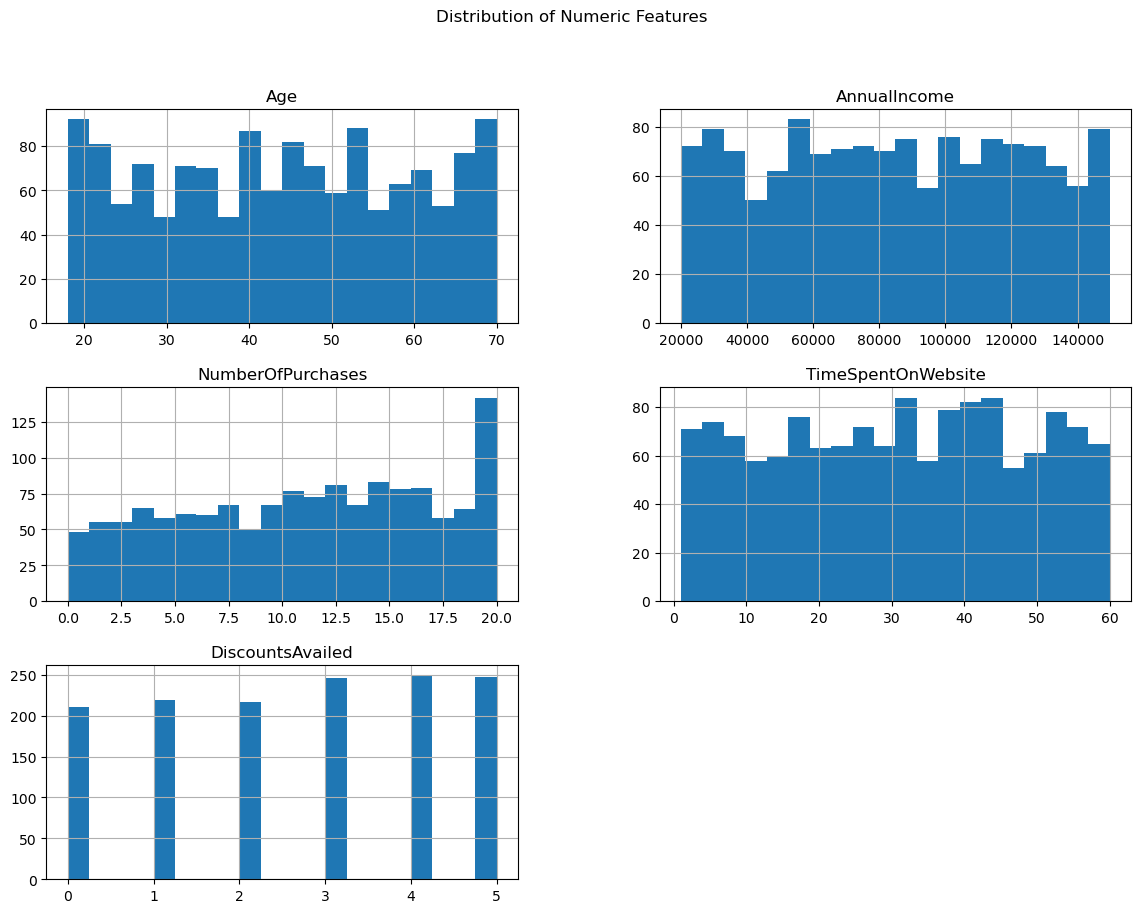

In [7]:
# Plotting the distribution of numeric features
numeric_features = ['Age', 'AnnualIncome', 'NumberOfPurchases', 'TimeSpentOnWebsite', 'DiscountsAvailed']
df[numeric_features].hist(bins=20, figsize=(14, 10))
plt.suptitle('Distribution of Numeric Features')
plt.show()

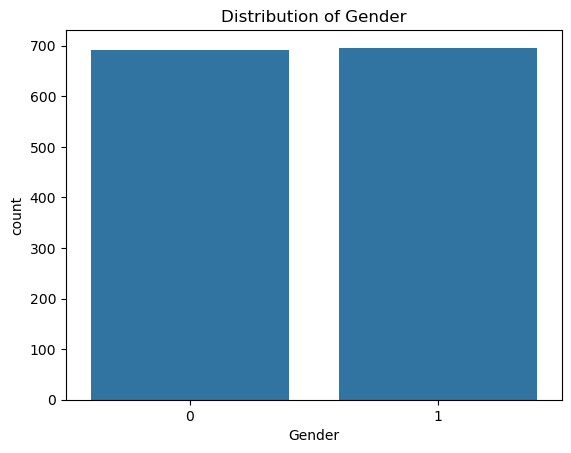

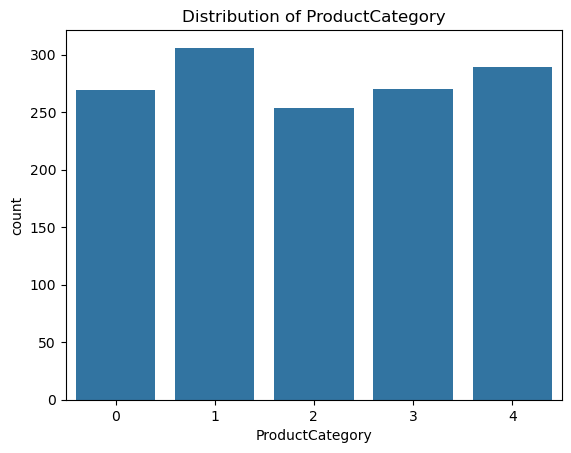

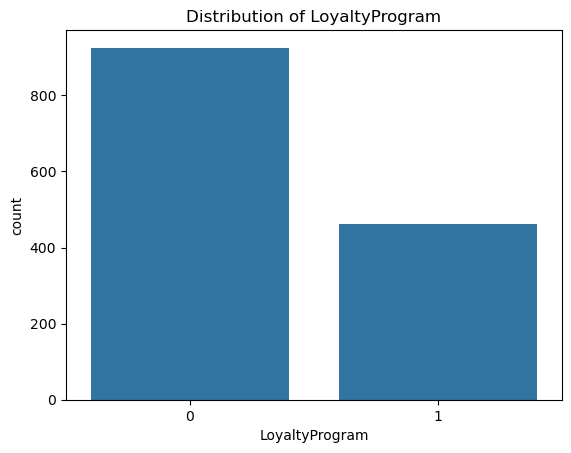

In [8]:
# Plotting the distribution of categorical features
categorical_features = df[['Gender', 'ProductCategory', 'LoyaltyProgram']]

for feature in categorical_features:
    sns.countplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()

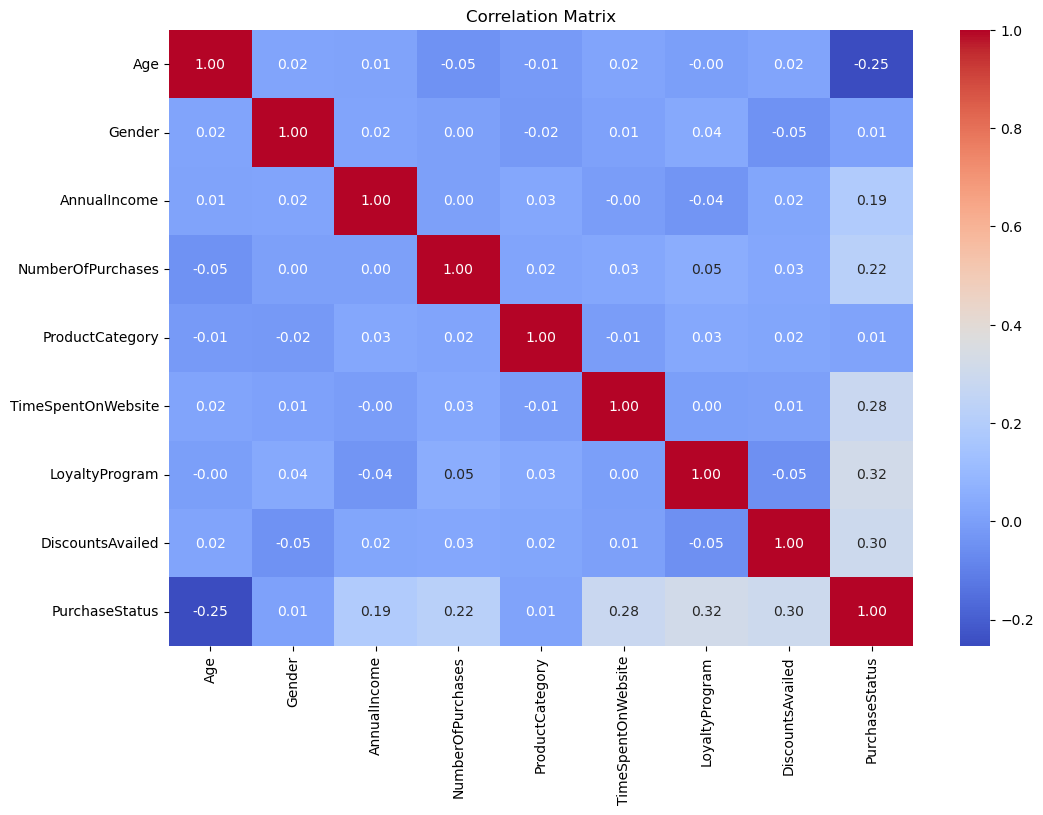

In [9]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Strongest Positive Correlations:**

LoyaltyProgram and PurchaseStatus (0.32): There is a moderate positive correlation between participation in a loyalty program and purchase status, suggesting customers in a loyalty program are more likely to make purchases.
DiscountsAvailed and PurchaseStatus (0.30): Customers who availed of discounts are more likely to complete purchases.
TimeSpentOnWebsite and PurchaseStatus (0.28): More time spent on the website correlates with a higher likelihood of completing a purchase.
NumberOfPurchases and PurchaseStatus (0.22): More frequent purchasing behavior correlates with completing a purchase.
AnnualIncome and PurchaseStatus (0.19): A mild positive correlation, suggesting higher income might slightly increase the likelihood of purchasing.

Gender shows weak correlations with all variables, suggesting it doesn't significantly influence purchase behavior.
ProductCategory has weak correlations with other features, indicating product type doesn't heavily influence purchase behavior in this dataset.

**Negative Correlations:**
Age and PurchaseStatus (-0.25): There is a negative correlation, indicating older customers are less likely to make purchases compared to younger ones.

**Summary:**
Loyalty programs, discounts, and time spent on the website positively influence purchase status.
Age negatively impacts purchasing behavior.
Gender and product category have minimal impact on purchase behavior in this dataset.

## **Preprocessing & Modeling**

### **Logistic Regression**

#### Starting with logisitc regression since it is best used for binary classification and that is what our target variable is. (PurchaseStatus)

In [14]:
# Define categorical and numeric features
categorical_features = ['Gender', 'ProductCategory', 'LoyaltyProgram']
numeric_features = ['Age', 'AnnualIncome', 'NumberOfPurchases', 'TimeSpentOnWebsite', 'DiscountsAvailed']

# Ensure X includes all the feature columns before any preprocessing
X = df[numeric_features + categorical_features]

# Target variable
y = df['PurchaseStatus']

# Define the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),       # Normalizing numeric features
        ('cat', OneHotEncoder(), categorical_features)   # Encoding categorical features
    ]
)

In [15]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# --- Logistic Regression Model ---
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Print accuracy and classification report for Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_lr))
print('-' * 80)

Logistic Regression Accuracy: 0.84
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       149
           1       0.83      0.83      0.83       129

    accuracy                           0.84       278
   macro avg       0.84      0.84      0.84       278
weighted avg       0.84      0.84      0.84       278

--------------------------------------------------------------------------------


#### Now we are going to use cross-validation to evaluate performance, tune hyperparamters, and reduce overfitting.

In [18]:
# Perform cross-validation with 5 folds
cv_scores_lr = cross_val_score(pipeline_lr, X, y, cv=5)

# Print cross-validation scores and their mean
print(f'Cross-validation scores: {cv_scores_lr}')
print(f'Mean accuracy: {cv_scores_lr.mean():.2f}')
print(f"Standard Deviation: {np.std(cv_scores_lr):.2f}")

Cross-validation scores: [0.8057554  0.81294964 0.81654676 0.80505415 0.81588448]
Mean accuracy: 0.81
Standard Deviation: 0.00


### **Random Forest Classifer**

#### Next we are going to use random forest classifier as it handles and works well with both numerical and categorical features which our data has, hopefully providing insights into which features contribute the most to purchase predictions.

In [21]:
# --- Random Forest Model ---
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Print accuracy and classification report for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('-' * 80)

Random Forest Accuracy: 0.93
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       149
           1       0.94      0.91      0.92       129

    accuracy                           0.93       278
   macro avg       0.93      0.93      0.93       278
weighted avg       0.93      0.93      0.93       278

--------------------------------------------------------------------------------


#### Now we are going to use cross-validation to evaluate performance, tune hyperparamters, and reduce overfitting.

In [23]:
# Perform Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_scores_rf = cross_val_score(pipeline_rf, X, y, cv=cv, scoring='accuracy')

# Print Cross-Validation Results
print("Cross-Validation Scores:", cv_scores_rf)
print(f"Mean Accuracy: {np.mean(cv_scores_rf):.2f}")
print(f"Standard Deviation: {np.std(cv_scores_rf):.2f}")

Cross-Validation Scores: [0.92086331 0.89208633 0.91726619 0.91696751 0.89891697]
Mean Accuracy: 0.91
Standard Deviation: 0.01


### **Gradient Boosting Classifier**

#### For our last model I chose gradient boosting as it likley will handle our weakily correlated data better than random forest can.

In [26]:
# --- Gradient Boosting Model ---
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_test)
y_pred_prob_gb = pipeline_gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_prob_gb)
auc_gb = auc(fpr_gb, tpr_gb)

# Print accuracy and classification report for Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print('Gradient Boosting Classification Report:')
print(classification_report(y_test, y_pred_gb))
print('-' * 80)

Gradient Boosting Accuracy: 0.92
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       149
           1       0.91      0.91      0.91       129

    accuracy                           0.92       278
   macro avg       0.92      0.92      0.92       278
weighted avg       0.92      0.92      0.92       278

--------------------------------------------------------------------------------


#### Now we are going to use cross-validation to evaluate performance, tune hyperparamters, and reduce overfitting.

In [28]:
# Perform Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
cv_scores_gb = cross_val_score(pipeline_gb, X, y, cv=cv, scoring='accuracy')

# Print Cross-Validation Results
print("Cross-Validation Scores:", cv_scores_gb)
print(f"Mean Accuracy: {np.mean(cv_scores_gb):.2f}")
print(f"Standard Deviation: {np.std(cv_scores_gb):.2f}")

Cross-Validation Scores: [0.91726619 0.92805755 0.91366906 0.93140794 0.92779783]
Mean Accuracy: 0.92
Standard Deviation: 0.01


#### Comparing the three models using ROC Curve

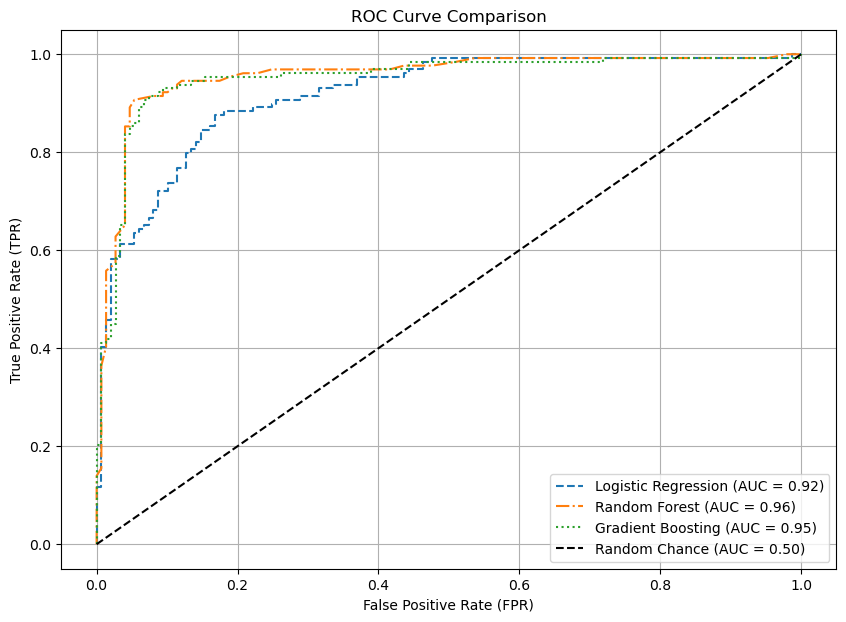

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle='-.')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})', linestyle=':')

# Plot the diagonal for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

#### Running a confusion matrix on the Random Forest model to help us visualize the distributions

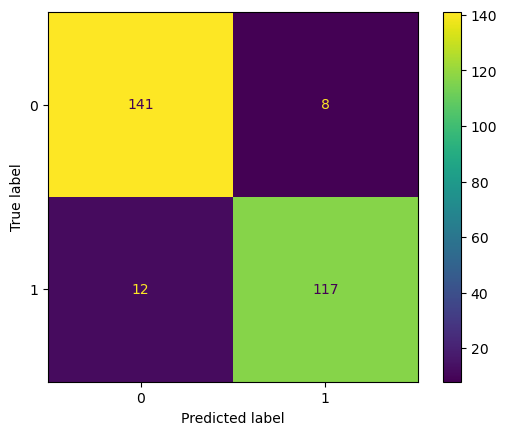

In [32]:
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm).plot()

There is a small imbalance in the false negatives (12) and false positives (8), but these errors are not excessive.
The model is slightly better at predicting no purchase "0" (141 correct predictions) compared to purchase "1"  (117 correct predictions).

### Lastly, I want to understand the relative importance of each feature as this is important in identifying key drivers of customer behavior and will impact future marketing strategies or customer engagement.

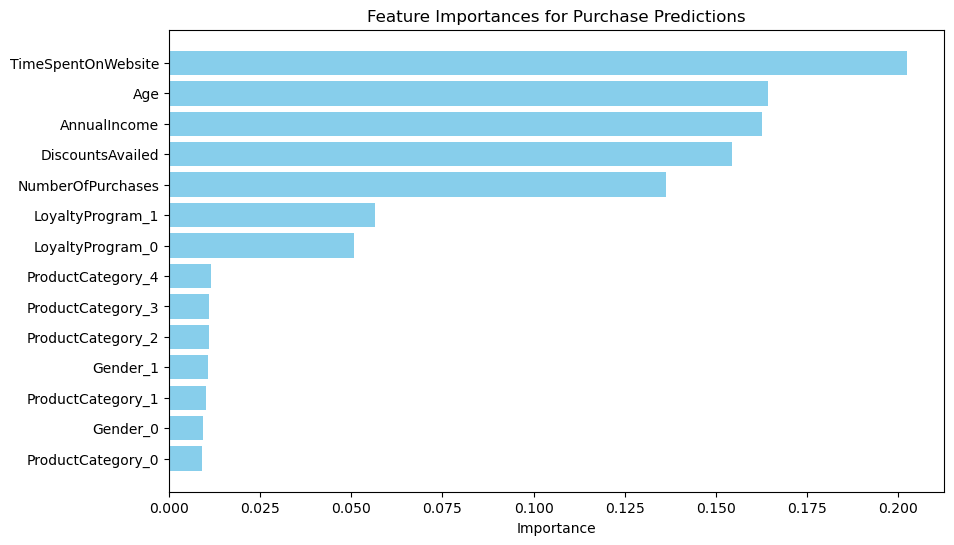

In [35]:
# Step 2: Extract feature importances
rf_model = pipeline_rf.named_steps['classifier']
importances = rf_model.feature_importances_

# Step 3: Extract transformed feature names
# Access preprocessor and identify transformers
preprocessor = pipeline_rf.named_steps['preprocessor']
num_features = preprocessor.transformers_[0][2]  # Numerical features
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(preprocessor.transformers_[1][2])  # Categorical features

# Combine all feature names
all_feature_names = np.concatenate([num_features, cat_features])

# Ensure lengths match
if len(importances) == len(all_feature_names):
    # Combine into a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    })

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Step 4: Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances for Purchase Predictions')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Mismatch between feature importances and feature names!")
    print(f"Importances length: {len(importances)}, Feature names length: {len(all_feature_names)}")

## **Conclusion**

#### While all three models performed well, Random Forest emerges as the best model for this task. It strikes a balance between test accuracy (93%) and cross-validation performance (91%), and it provides interpretability through feature importance, which is valuable for identifying the most influential factors like age, gender, and income. Random forest also had the highest AUC indicating better performance amongst the three. Gradient Boosting is a close second, with slightly better cross-validation accuracy (92%) but slightly lower precision and recall on the test set. Logistic Regression, while simpler and easier to implement, underperforms in comparison.

#### We also learned that the time spent on the website significantly impacts whether or not a purchase is made, indicating that the more time spent, the more likely a purchase will be made. This is great information for a marketing team to target this demographic with discounts to leverage the likleyhood of a purchase.